# Final Project - Personalization Theory

Authors: *Bertrand Thia-Thiong-Fat, Jeremy Yao, Paul Doan*

## Loading the data

In [27]:
# Importing the libraries used

import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import sklearn.model_selection 
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec 

In [28]:
# Loading the data
line_count = len(open("yelp_dataset/review.json").readlines())
user_ids, business_ids, stars, dates = [], [], [], []

with open("yelp_dataset/review.json") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        user_ids += [blob["user_id"]] 
        business_ids += [blob["business_id"]] 
        stars += [blob["stars"]]
        dates += [blob["date"]]
            
Ratings = pd.DataFrame({"user_id": user_ids, "business_id": business_ids, 
                        "rating": stars, "date": dates})

# Cleaning data and variables - keeping only the active users i.e. those who have more than 5 reviews
Ratings['date'] = pd.to_datetime(Ratings['date'])

# Sorting and showing the dataframe
Ratings.sort_values('date', ascending=False, inplace=True)
Ratings.head()

100%|██████████| 6685900/6685900 [00:49<00:00, 133837.27it/s]


,user_id,business_id,rating,date
3986173,fu-jsnkPbj4zhI2lz0ewkQ,wItXs66eEADndAGl-u_lpw,5.0,2018-11-14 18:13:26
5226537,UTNefnQ3eZEbIxVu7ALO7Q,S0DRkPCiMRmMtIPVM54FRw,5.0,2018-11-14 18:13:16
2564946,222_8pOPN2Ogy-gLNjudHw,0d0i0FaJq1GIeW1rS2D-5w,3.0,2018-11-14 18:12:40
3981102,A9Z4tpG4xt06lCxFUU5khw,1e7GXqhVDs0UXUofjTkVgQ,5.0,2018-11-14 18:12:18
3232065,a6NY1dBAYXZMBDxtWU6Zjw,ovQDI5j3aRIw_y73IdnqVg,5.0,2018-11-14 18:12:08


## Utility function

Let us perform some data analyses on the set of data at hand. Here are some functions that will be useful in our study:

In [29]:
# Plot the distribution of the ratings in our dataset

def distribution(review):
    #Get the distribution of the ratings
    x=review['rating'].value_counts()
    x=x.sort_index()
    #plot
    plt.figure(figsize=(8,4))
    ax= sns.barplot(x.index, x.values, alpha=0.8)
    plt.title("Rating Distribution")
    plt.ylabel('# of reviews', fontsize=12)
    plt.xlabel('Ratings ', fontsize=12)
    #adding the text labels
    rects = ax.patches
    labels = x.values
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    plt.show()
    
    #Get the proportion of the ratings
    x=review['rating'].value_counts().divide(len(review))
    x=x.sort_index()
    #plot
    plt.figure(figsize=(8,4))
    plt.bar(x.index, x.values,width=0.4)
    plt.title("Rating Distribution")
    plt.ylabel('% of reviews', fontsize=12)
    plt.xlabel('Ratings ', fontsize=12)

In [30]:
# plot the average ratings and the cumulative distribution of user reviews

def ratings_dist(df):
    data = df.groupby('user_id').agg({'date':['count']})
    
    data[('date','count')].loc[data[('date','count')]>100] = 100
    plt.figure(figsize=(12,5))
    plt.suptitle("Reviews per User Distribution",fontsize=20)
    gridspec.GridSpec(1,2)
    plt.subplot2grid((1,2),(0,0))
    #Cumulative Distribution
    ax=sns.kdeplot(data[('date','count')],shade=True,color='r')
    plt.title("# of reviews an average user gives",fontsize=15)
    plt.xlabel('# of reviews given', fontsize=12)
    plt.ylabel('# of users', fontsize=12)

    #Cumulative Distribution
    plt.subplot2grid((1,2),(0,1))
    sns.distplot(data[('date','count')],
             kde_kws=dict(cumulative=True))
    plt.title("Cumulative dist. of user reviews",fontsize=15)
    plt.ylabel('Cumulative perc. of users', fontsize=12)
    plt.xlabel('# of reviews given', fontsize=12)

In [31]:
# Plot the # of ratings per items

def ratings_per_item(df):
    data = df['business_id'].value_counts()
    data.hist(bins = [i for i in range(0,100)])

In [32]:
# Plot the # of ratings per users

def ratings_per_user(df):
    data = df['user_id'].value_counts()
    data.hist(bins = [i for i in range(0,100)])

In [33]:
# Compute the average global rating of our dataset

def average_global_rating(df):
    dif_users = df.groupby('user_id', as_index=False).mean()
    average_global_rating = round(dif_users['rating'].mean(), 2)
    return average_global_rating

## Analyses of the whole dataset

First, let us extract the active users i.e. the users who rated more than 5 businesses - as we are going to focus on them during our study. 

In [34]:
user_counts = Ratings["user_id"].value_counts()
active_users = user_counts[user_counts >= 5].index.tolist()
Ratings_ = Ratings[Ratings['user_id'].isin(active_users)]

Here are then some information about our dataset:

In [35]:
print('There are {} active users. \nThey add up to a total of {} unique ratings. \nThere are {} different businesses'.format(Ratings_["user_id"].nunique(), Ratings_.shape[0], Ratings_["business_id"].nunique()))

There are 286130 active users. 
They add up to a total of 4538272 unique ratings. 
There are 185723 different businesses


There are approximately 1.54 times more users than businesses in our dataset.

In [36]:
mean_Ratings = average_global_rating(Ratings_)
print('Average global rating:', mean_Ratings)

Average global rating: 3.76


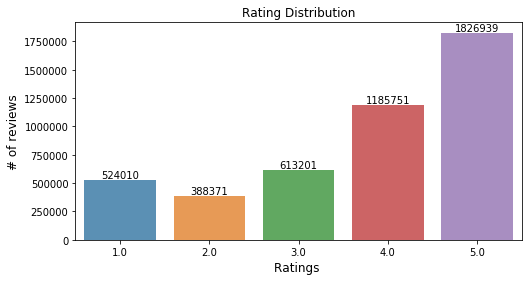

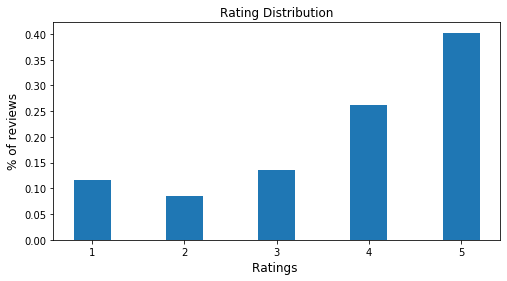

In [37]:
distribution(Ratings_)

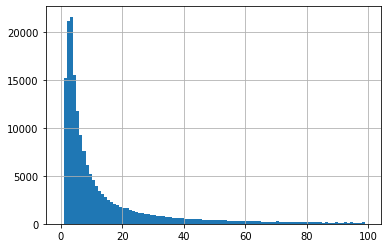

In [38]:
ratings_per_item(Ratings_)

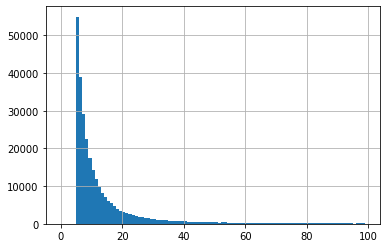

In [39]:
ratings_per_user(Ratings_)

We can observe as expected a long tail effect on our set of data.

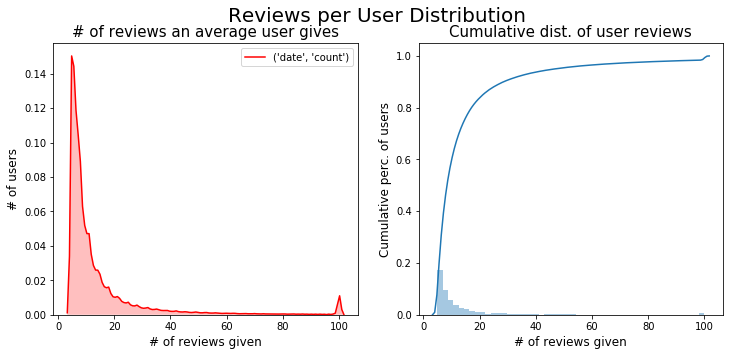

In [40]:
ratings_dist(Ratings_)

## Construction of our dataset

Let us now sample our dataset to reduce its size. It will hence be easier to train our models later. 
<br>**The ideal would be to construct it to be representative of the real dataset**. We will therefore try to keep the characteristics of the original dataset somewhat. However, we will not try to keep the distribution of the different categories (that can be observed in the *business.json* file) as there are too many different of them in our set of data. To use this information in a relevant way, we would need to reduce the number of categories by clustering them in bigger buckets - which we do not have time to do in this study unfortunately.

**We are going to sample our data to keep approximately 30,000 distinct users and 5,000 distinct business in the end.**

In [41]:
np.random.seed(1)

threshold = 55

# Keeping the business with more than a certain number of reviews
counts = Ratings['business_id'].value_counts()
ratings = Ratings[Ratings['business_id'].isin(counts.index[counts > threshold])]
# Narrowing the number of businesses
unique_business = ratings['business_id'].unique()
sample = np.random.choice(unique_business, 5000, replace=False)
ratings = ratings[ratings['business_id'].isin(sample)]
    
# Keeping users that have more than 5 ratings
user_counts = ratings["user_id"].value_counts()
active_users = user_counts[user_counts >= 5].index.tolist()
dataset = ratings[ratings['user_id'].isin(active_users)]

In [42]:
print('There are {} active users. \nThey add up to a total of {} unique ratings. \nThere are {} different businesses'.format(dataset["user_id"].nunique(), dataset.shape[0], dataset["business_id"].nunique()))

There are 30750 active users. 
They add up to a total of 317153 unique ratings. 
There are 4996 different businesses


## Analyses of our sampling

Let us determine the average global rating of our dataset: 

In [43]:
mean_Ratings = average_global_rating(dataset)
print('Average global rating:', mean_Ratings)

Average global rating: 3.8


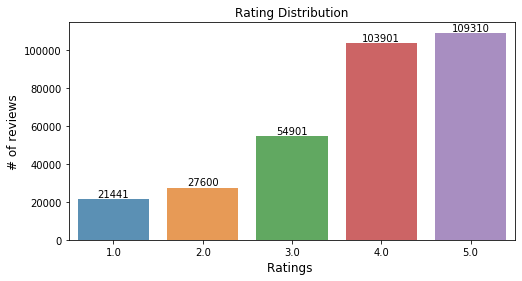

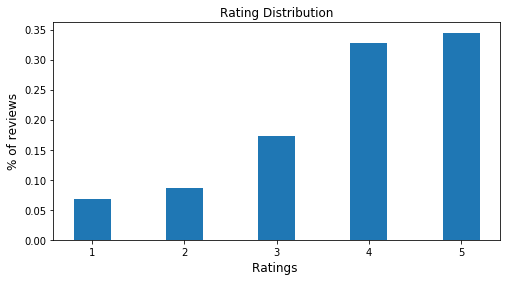

In [44]:
distribution(dataset)

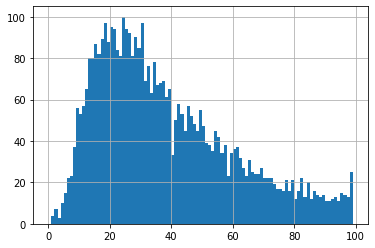

In [45]:
ratings_per_item(dataset)

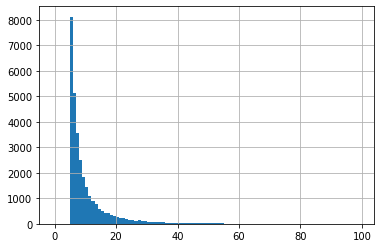

In [46]:
ratings_per_user(dataset)

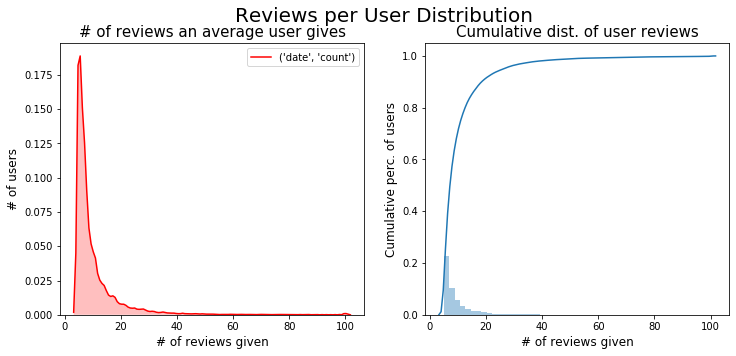

In [47]:
ratings_dist(dataset)

**It is complex to keep the original rating distribution while reducing the size of the dataset:**
<br>
* We want to keep the users that have more than a certain number of ratings: since the task under study is predicting the last rating of the users, we need some data about them so that our models can learn about their preferences. We set this number to 5 because there is a long tail effect on the number of ratings per user, hence decreasing this number also decreases the number of potential users under study significantly. 

* It is difficult to select 5,000 distinct businesses randomly and get a minimum of 5 ratings per users at the same time because of the long tail effect. To remedy to this problem, we set a threshold regarding the number of reviews per business so that we could end up with around 40,000 users approximately while selecting 5,000 distinct businesses randomly (among the ones filtered by our threshold). 
<br>
*Note*: Raising the threshold allows to get more users with a minimum of 5 ratings. Indeed, this leads to consider more popular businesses with a lot of reviews. As a result, we are also considering more users who are likely to have rated these popular businesses. However, by doing so we lose the long tail effect on our dataset, and we tend to work with popular businesses only. We tried to find a trade-off to get a good number of users while not deteriorating the long tail effect too much - and end up with a dataset not representative of the original one.

**In the end**, regarding what we wrote above, we conducted some experiments and ended up with the dataset above. It has roughly **an average global mean close to the original dataset** even though the rating distribution is a bit different. Still, **the overall proportions look similar enough for our study**. Also, we can observe **a long tail effect** indicating that we are not only working with popular items and users only. 
<br>Finally our reduced dataset conserves the overall characteristics of the original dataset. We will hence work with it during our study.

## Saving the dataset

In [23]:
dataset.to_csv('dataset.csv')